In [2]:
from kan import *

# create a KAN: 2D inputs, 1D output, and 5 hidden neurons. cubic spline (k=3), 5 grid intervals (grid=5).
model = KAN(width=[2, 5, 1], grid=5, k=3, seed=0)

Create dataset

In [3]:
# create dataset f(x,y) = exp(sin(pi*x)+y^2)
f = lambda x: torch.exp(torch.sin(torch.pi * x[:, [0]]) + x[:, [1]] ** 2)
# g = lambda x: torch.exp(torch.cos(torch.pi * x[:, [0]]) + x[:, [1]] ** 3 + x[:,[2]]*x[:, [0]])
torch.manual_seed(0)
dataset = create_dataset(f, n_var=2)

dataset["train_input"].shape, dataset["train_label"].shape

(torch.Size([1000, 2]), torch.Size([1000, 1]))

Plot KAN at initialization

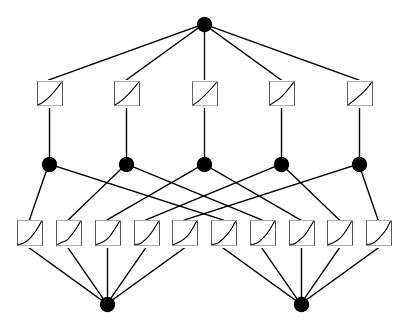

In [3]:
# plot KAN at initialization
model(dataset["train_input"])
model.plot(beta=100)

Train KAN with sparsity regularization

In [4]:
# train the model
model.train(dataset, opt="LBFGS", steps=20, lamb=0.01, lamb_entropy=10.0);

train loss: 1.56e-01 | test loss: 1.32e-01 | reg: 2.04e+01 : 100%|██| 20/20 [00:10<00:00,  1.96it/s]


Plot trained KAN

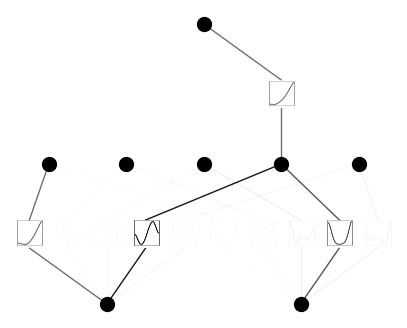

In [5]:
model.plot()

Prune KAN and replot (keep the original shape)

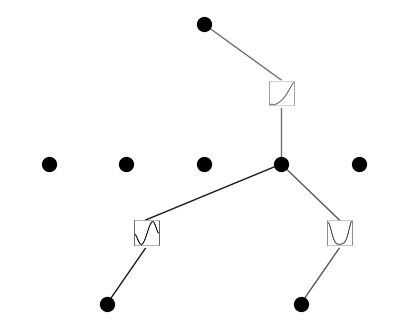

In [6]:
model.prune()
model.plot(mask=True)

Prune KAN and replot (get a smaller shape)

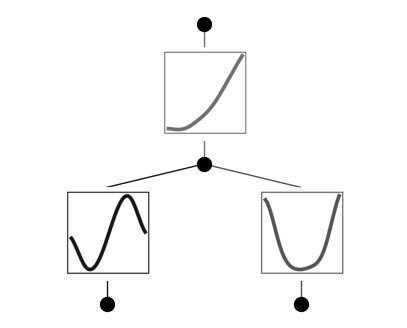

In [7]:
model = model.prune()
model(dataset["train_input"])
model.plot()

Continue training and replot

In [8]:
model.train(dataset, opt="LBFGS", steps=50);

train loss: 4.74e-03 | test loss: 4.81e-03 | reg: 2.96e+00 : 100%|██| 50/50 [00:04<00:00, 11.97it/s]


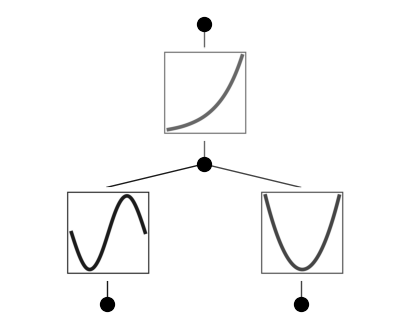

In [9]:
model.plot()

Automatically or manually set activation functions to be symbolic

In [10]:
mode = "auto"  # "manual"

if mode == "manual":
    # manual mode
    model.fix_symbolic(0, 0, 0, "sin")
    model.fix_symbolic(0, 1, 0, "x^2")
    model.fix_symbolic(1, 0, 0, "exp")
elif mode == "auto":
    # automatic mode
    lib = ["x", "x^2", "x^3", "x^4", "exp", "log", "sqrt", "sin", "abs"] 
    model.auto_symbolic(lib=lib)

fixing (0,0,0) with sin, r2=0.9999867600218375
fixing (0,1,0) with x^2, r2=0.9999997148826716
fixing (1,0,0) with exp, r2=0.9999988306610816


Continue training to almost machine precision

In [11]:
model.train(dataset, opt="LBFGS", steps=50);

train loss: 4.75e-10 | test loss: 4.71e-10 | reg: 2.96e+00 : 100%|██| 50/50 [00:02<00:00, 23.66it/s]


Obtain the symbolic formula

In [12]:
model.symbolic_formula()[0][0]

1.0*exp(1.0*x_2**2 + 1.0*sin(3.14*x_1))

# Flakiness of the model

In [13]:
model = KAN(width=[2, 6, 1], grid=5, k=3, seed=200)
model.train(dataset, opt="LBFGS", steps=20, lamb=0.01, lamb_entropy=10.0)
model = model.prune()
model.train(dataset, opt="LBFGS", steps=50)
model.auto_symbolic(lib=["x", "x^2", "x^3", "x^4", "exp", "log", "sqrt", "sin", "abs"])
model.train(dataset, opt="LBFGS", steps=50)
model.symbolic_formula()[0][0]

train loss: 1.52e-01 | test loss: 1.49e-01 | reg: 2.74e+01 : 100%|██| 20/20 [00:11<00:00,  1.79it/s]
train loss: 4.32e-03 | test loss: 4.52e-03 | reg: 8.71e+00 : 100%|██| 50/50 [00:12<00:00,  4.16it/s]


fixing (0,0,0) with sin, r2=0.9960927173312121
fixing (0,0,1) with x^2, r2=0.9989899690622195
fixing (0,0,2) with sin, r2=0.9945000284251424
fixing (0,1,0) with sin, r2=0.9899727499453378
fixing (0,1,1) with sin, r2=0.999895213924865
fixing (0,1,2) with sin, r2=0.9990616465349637
fixing (1,0,0) with sin, r2=0.980343190907015
fixing (1,1,0) with sin, r2=0.9968497877104819
fixing (1,2,0) with exp, r2=0.994990556347489


train loss: 6.74e-02 | test loss: 7.18e-02 | reg: 8.87e+00 : 100%|██| 50/50 [00:17<00:00,  2.82it/s]


0.4*exp(-1.03*sin(3.22*x_1 - 3.24) - 1.59*sin(2.68*x_2 + 1.57)) + 0.34*sin(1.14*(-1.0*x_1 - 1)**2 + 0.13*sin(2.1*x_2 - 1.58) + 4.48) - 0.83*sin(7.95*sin(0.65*x_1 - 0.8) + 0.1*sin(1.19*x_2 - 1.57) - 3.93) + 1.52

# Using PYSR instead

In [4]:
from pysr import PySRRegressor

In [7]:
model = PySRRegressor(
    niterations=300,  # < Increase me for better results
    binary_operators=["+", "*"],
    unary_operators=[
        "cos",
        "exp",
        "sin",
    ],
    random_state=0,
    temp_equation_file=True
)

model.fit(dataset["train_input"], dataset["train_label"])

/Users/theowolf/Library/Caches/pypoetry/virtualenvs/kan-nPMFjNpS-py3.10/lib/python3.10/site-packages/pysr/sr.py:1256: UserWarning: Note: Setting `random_state` without also setting `deterministic` to True and `procs` to 0 will result in non-deterministic searches. 
  warnings.warn(
/Users/theowolf/Library/Caches/pypoetry/virtualenvs/kan-nPMFjNpS-py3.10/lib/python3.10/site-packages/pysr/sr.py:1307: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 8.660e+04
Head worker occupation: 11.6%
Progress: 192 / 4500 total iterations (4.267%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
2           1.905e+00  7.971e+00  y = exp(x₀)
3           1.380e+00  3.227e-01  y = 1.836 + x₀
4           1.377e+00  1.998e-03  y = sin(x₀) + 1.8376
5           1.208e+00  1.308e-01  y = exp(sin(0.70017 + x₀))
6           1.060e+00  1.313e-01  y = exp(sin(exp(x₀))) + x₀
7           7.533e-01  3.412e-01  y = 0.39697 + exp(sin(3.1416 * x₀))
8           7.334e-01  2.677e-02  y = exp(-0.32922) + exp(sin(x₀ * 3.1416))
9           4.913e-01  4.006e-01  y = exp(sin(3.0578 * x₀)) + (x₁ * x₁)
11          1.125e-12  7.971e+00  y = exp(sin(x₀ * 3.1416) + (x₁ * x₁)) + -1.5315e-07
17          1.123e-12  2.451e-04  y = ((sin(2.2704) * cos(1.5708)) * -0.78772) + exp((x₁ * x₁) +...
                                   sin(3.1416 

PySRRegressor.equations_ = [
	   pick      score                                           equation  \
	0         0.000000                                          1.8347753   
	1         0.072610                                            exp(x0)   
	2         0.322661                                      1.836044 + x0   
	3         0.001998                                sin(x0) + 1.8372726   
	4         0.267417                            exp(sin(2.939477 * x0))   
	5         0.190697                     sin(x0 * 3.065587) + 1.8540729   
	6         0.447671                1.4822283 * exp(sin(x0 * 3.196888))   
	7  >>>>  13.453181               exp((x1 * x1) + sin(x0 * 3.1415913))   
	8         0.010739  exp(sin(x0 * 3.1415913) + (x1 * x1)) + -1.5314...   
	9         0.000245  ((sin(2.270382) * cos(1.570796)) * -0.7877236)...   
	
	           loss  complexity  
	0  2.048939e+00           1  
	1  1.905438e+00           2  
	2  1.379955e+00           3  
	3  1.377200e+00           4  
	4  1.054045e+00           5  
	5  8.710455e-01           6  
	6  5.566981e-01           7  
	7  1.149041e-12           9  
	8  1.124624e-12          11  
	9  1.122971e-12          17  
]

In [8]:
model.sympy()

exp(x1**2 + sin(3.1415913*x0))

In [9]:
# Changing the seed
model = PySRRegressor(
    niterations=300,  # < Increase me for better results
    binary_operators=["+", "*"],
    unary_operators=[
        "cos",
        "exp",
        "sin",
    ],
    random_state=1,
    temp_equation_file=True
)

model.fit(dataset["train_input"], dataset["train_label"])
model.sympy()

/Users/theowolf/Library/Caches/pypoetry/virtualenvs/kan-nPMFjNpS-py3.10/lib/python3.10/site-packages/pysr/sr.py:1256: UserWarning: Note: Setting `random_state` without also setting `deterministic` to True and `procs` to 0 will result in non-deterministic searches. 
  warnings.warn(
/Users/theowolf/Library/Caches/pypoetry/virtualenvs/kan-nPMFjNpS-py3.10/lib/python3.10/site-packages/pysr/sr.py:1307: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 9.400e+04
Head worker occupation: 11.9%
Progress: 208 / 4500 total iterations (4.622%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
2           1.905e+00  7.971e+00  y = exp(x₀)
3           1.380e+00  3.227e-01  y = x₀ + 1.8362
4           1.377e+00  1.998e-03  y = 1.8362 + sin(x₀)
5           1.208e+00  1.308e-01  y = exp(sin(0.70783 + x₀))
6           9.980e-01  1.913e-01  y = exp((x₁ * x₁) + x₀)
7           7.169e-01  3.308e-01  y = exp(sin(3.1416 * x₀)) + 0.56682
8           6.684e-01  7.008e-02  y = exp(sin(x₀ * 3.8342)) * exp(x₀)
9           2.134e-01  1.142e+00  y = exp((x₁ * x₁) + sin(x₀ * 2.5424))
10          8.780e-11  1.594e+01  y = exp((x₁ * x₁) + sin(x₀ * exp(1.1447)))
11          1.114e-12  4.367e+00  y = exp((x₁ * x₁) + sin(x₀ * 3.1416)) + -1.3918e-07
13          3.182e-13  6.266e-01  y = -4.3937e-07 + exp((x₁ * x₁) + sin(1.772

exp(x1**2 + sin(3.14159253834692*x0)) + 1.18299596e-7